In [1]:
import random
random.seed(0)
import tensorflow as tf
tf.keras.utils.set_random_seed(0)
from tensorflow import keras

import glob
import os
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Flatten, Input, Rescaling, Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks  import EarlyStopping, ReduceLROnPlateau

## Extracting the zip files

In [2]:
with ZipFile('face_mask_dataset.zip', 'r') as face_masks:
  face_masks.extractall()

In [3]:
train = tf.keras.utils.image_dataset_from_directory('face_mask_dataset/train', shuffle = True, seed = 0)
test = tf.keras.utils.image_dataset_from_directory('face_mask_dataset/test', shuffle = True, seed = 0)
val = tf.keras.utils.image_dataset_from_directory('face_mask_dataset/val', shuffle = True, seed = 0)

Found 5287 files belonging to 2 classes.
Found 757 files belonging to 2 classes.
Found 1510 files belonging to 2 classes.


In [4]:
l = train.class_names
l

['with_mask', 'without_mask']

In [5]:
labels = {i :j for i, j in enumerate(l)}
labels

{0: 'with_mask', 1: 'without_mask'}

## Data preprocesing

In [6]:
scaler = Sequential([Rescaling(1.0/225), Resizing(128, 128)])

train = train.map(lambda x, y : (scaler(x), y))
test = test.map(lambda x, y : (scaler(x), y))
val = val.map(lambda x, y : (scaler(x), y))

In [7]:
classes = os.listdir('face_mask_dataset/train')
classes

['without_mask', 'with_mask']

In [8]:
test_classes = os.listdir('face_mask_dataset/test')
test_classes

['without_mask', 'with_mask']

In [9]:
image = {}
count = {}
for i in classes:
  file_path = glob.glob(f'face_mask_dataset/train/{i}/*')
  count[i] = len(file_path)
  image_path = random.choice(file_path)
  image[i] = tf.keras.utils.load_img(image_path)


In [10]:
image

{'without_mask': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168>,
 'with_mask': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x682>}

In [11]:
count

{'without_mask': 2679, 'with_mask': 2607}

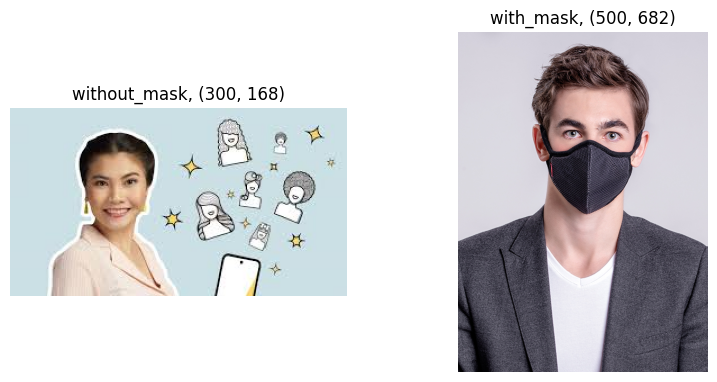

In [12]:
plt.figure(figsize=(20, 15))

for i, (cls, img) in enumerate(image.items()):
  ax = plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f'{cls}, {img.size}')
  plt.axis('off')

In [13]:
# l2reg = keras.regularizers.L2(l2 = 1e-4)

# model = Sequential([

#     Conv2D(30, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (128, 128, 3), kernel_regularizer = l2reg),
#     Conv2D(40, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     Conv2D(50, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     BatchNormalization(),
#     MaxPooling2D(pool_size = (3,3)),
#     Dropout(0.3),

#     Conv2D(120, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     Conv2D(150, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     BatchNormalization(),
#     MaxPooling2D(pool_size = (3,3)),
#     Dropout(0.3),

#     Conv2D(190, kernel_size = (2,2), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     Conv2D(200, kernel_size = (2,2), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     Conv2D(220, kernel_size = (2,2), padding = 'same', activation = 'relu',kernel_regularizer = l2reg),
#     BatchNormalization(),
#     MaxPooling2D(pool_size = (2,2)),
#     Dropout(0.3),

#     Conv2D(250, kernel_size = (3,3), padding = 'same', activation = 'relu',kernel_regularizer = l2reg),
#     Conv2D(280, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2reg),
#     MaxPooling2D(pool_size = (2,2)),
#     BatchNormalization(),
#     Dropout(0.3),

#     GlobalAveragePooling2D(),
#     Dense(120, activation = 'relu', kernel_regularizer = l2reg),
#     Dense(180, activation = 'relu', kernel_regularizer = l2reg),
#     Dense(1, activation = 'sigmoid')
# ])

In [14]:
model = Sequential([

    Conv2D(32, 3, activation='relu', padding='same', input_shape = (128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3,
                                                  mode = 'max',
                                                  restore_best_weights = True)

In [18]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
                                                       filepath='tf_model.keras',
                                                       save_best_only = True,
                                                       mode = 'max')

In [19]:
history = model.fit(train, epochs = 20, batch_size = 128, validation_data = val, verbose = 1,
                    callbacks = [early_stopping, model_check_point]
                    )

Epoch 1/20


166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7804 - loss: 0.4760 - val_accuracy: 0.5742 - val_loss: 0.6691
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8812 - loss: 0.2890 - val_accuracy: 0.6483 - val_loss: 0.6502
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9277 - loss: 0.1868 - val_accuracy: 0.8960 - val_loss: 0.2625
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9374 - loss: 0.1600 - val_accuracy: 0.9238 - val_loss: 0.2030
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9595 - loss: 0.1128 - val_accuracy: 0.9099 - val_loss: 0.2220
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9648 - loss: 0.1019 - val_accuracy: 0.9477 - val_loss: 0.1308
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9688 - loss: 0.0930 - val_accuracy: 0.8808 - val_loss: 0.2723
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9707 - loss: 0.0781 - val_accuracy: 0.959

In [20]:
model.evaluate(train)

166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.9856 - loss: 0.0434


[0.043445099145174026, 0.985625147819519]

In [21]:
model.evaluate(val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9702 - loss: 0.1005


[0.1004667803645134, 0.9701986908912659]

In [22]:
model.evaluate(test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - accuracy: 0.9709 - loss: 0.0955


[0.09546970576047897, 0.9709379076957703]

In [23]:
import matplotlib.pyplot as plt

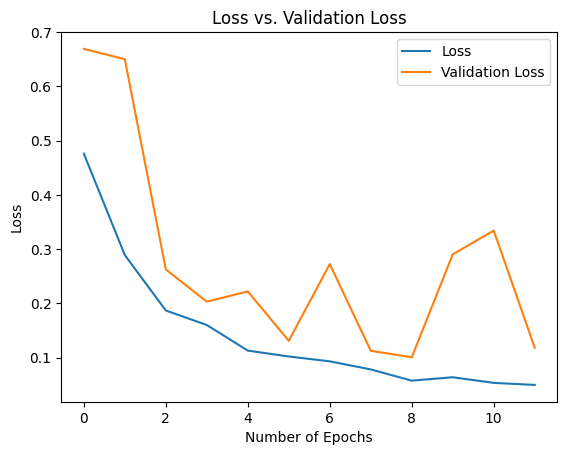

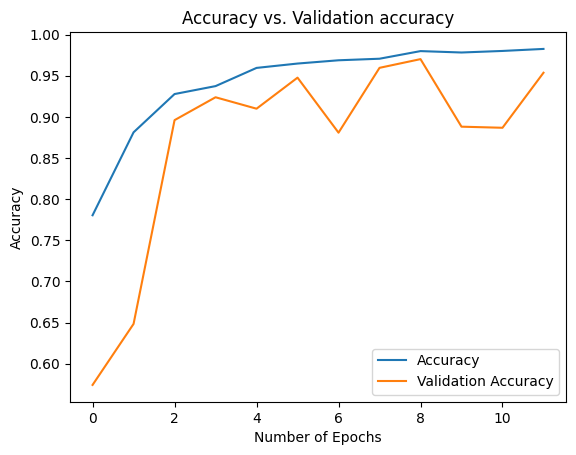

In [24]:
plt.plot(history.epoch, history.history['loss'], label='Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
def show_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    preprocessed_img = tf.expand_dims(img, axis = 0)
    predict = model.predict(preprocessed_img)[0]
    label = 'without_mask' if predict >= 0.5 else 'with_mask'

    plt.imshow(img)
    plt.title(f'Prediction : {label} (confidence : {predict[0]:.2f})')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


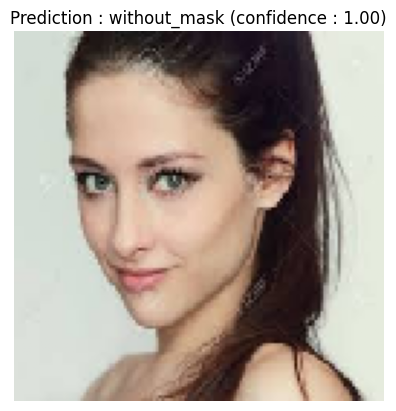

In [35]:
p = show_predict('all_images/images.jpg')
p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


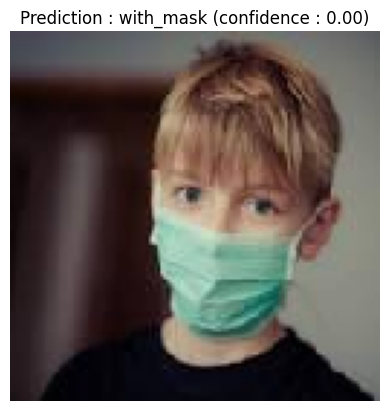

In [36]:
q = show_predict('all_images/child_mask.jpg')
q

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


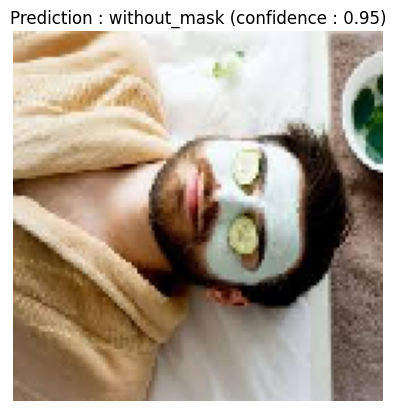

In [37]:
r = show_predict('all_images/face_pack.jpg')
r

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


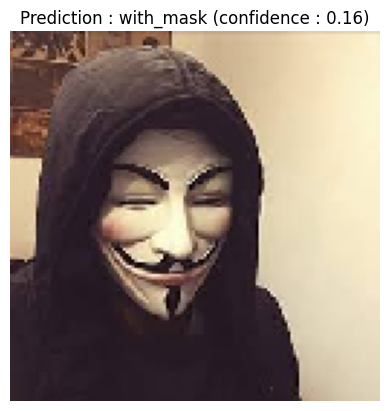

In [38]:
s = show_predict('all_images/full_mask.jpg')
s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


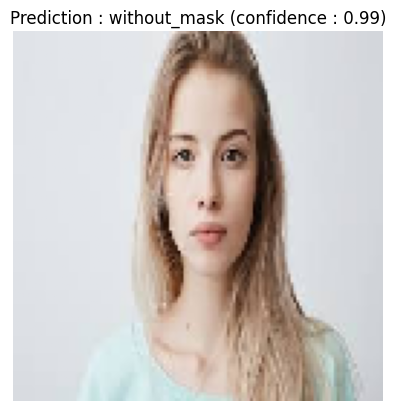

In [39]:
s = show_predict('all_images/girl.jpg')
s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


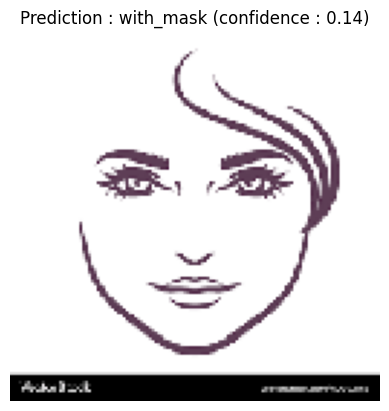

In [40]:
t = show_predict('all_images/sketch.png')
t